In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV,MultiTaskLassoCV
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Lasso, LogisticRegression
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization,LSTM

print(tf.keras.__version__)
print(tf.__version__)
from data_creater import *
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2.2.4-tf
2.0.0


### Vanilla NN model

In [2]:
def VanillaNN(state,predictor_state = None,if_plot=True,if_gt = True,lag = 1):
    # def Neural network
    def NN(X_train,y_train,batch_size,epochs,verbose):
        drop_rate = .01
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = batch_size
        epochs = epochs
        validation_split = 0.1
        verbose = verbose
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(input_dim=len(X_train.keys()),units = 128,activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
        model.add(tf.keras.layers.Dense(units = 64,activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
        model.add(tf.keras.layers.Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X_train, X_test, X, y_train, y_test, y_all,scaler = get_data(state, 
                                                      lag,
                                                      with_gt=if_gt,
                                                      predictor_state=predictor_state)
    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)
    
    # Training Model
    if predictor_state == None:
        predictor_state = ['flu_data']
    for i in range(26):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
     
    clf = LassoCV(alphas = [.1, .01, .001, .0001, .00001], tol = 0.05)
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = NN(X_train,y_train,32,10,0)
    preds = nn.predict(X_test)
    reverse_preds = scaler.inverse_transform(preds)
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, reverse_preds)))
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(reverse_preds, label='predicted')
        plt.legend()
        plt.show() 
    return reverse_preds

In [30]:
NN_TS1 = VanillaNN('Texas',None,False,False,1)
# Autocorrelation without GT
NN_TSOS1 = VanillaNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False, False,1)
# With goolge trend
NN_TSGT1 = VanillaNN('Texas',None,False,True,1)
# With goolge trend
NN_TSOSGT1 = VanillaNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)

Test RMSE:  1.017470139055414
Test RMSE:  1.159210288548478
Test RMSE:  1.395811537586204
Test RMSE:  1.5990903134614267


In [32]:
def plot_prediction(TS,TSOS,TSGT,TSOSGT):
    _, _, _, _, y_test, y_all,scaler = get_data('Texas', 1,with_gt=False,predictor_state=None)
    y_test = y_test.values.reshape(-1,)
    fig,ax = plt.subplots(2,2,figsize = (15,10))
    ax[0][0].plot(y_test.tolist(), label='true')
    ax[0][0].plot(TS, label='predicted TS only')
    ax[0][1].plot(y_test.tolist(), label='true')
    ax[0][1].plot(TSOS, label='predicted TS and other state')
    ax[1][0].plot(y_test.tolist(), label='true')
    ax[1][0].plot(TSGT, label='predicted TS and GT')
    ax[1][1].plot(y_test.tolist(), label='true')
    ax[1][1].plot(TSOSGT, label='predicted TS,other state and GT')
    ax[0][0].legend()
    ax[0][1].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    fig.suptitle("Prediction for NN model for Texas",size = 20)

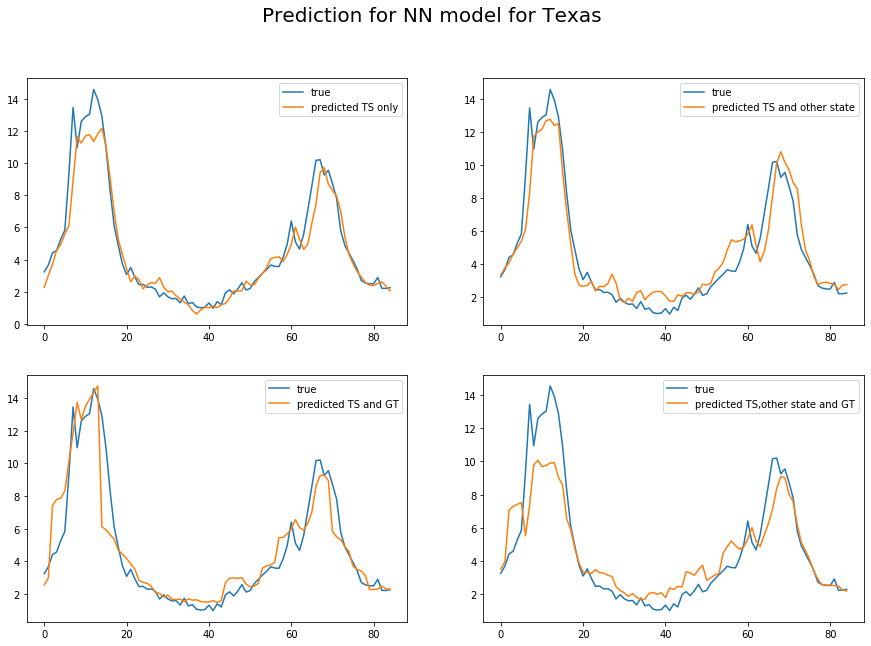

In [33]:
plot_prediction(NN_TS1,NN_TSOS1,NN_TSGT1,NN_TSOSGT1)

### RNN Model

In [38]:
def RNN(state,predictor_state = None,if_plot=True,if_gt = True,lag = 1):
    # def Neural network
    def rnn(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = 32
        epochs = 10
        validation_split = 0.1
        verbose = 0
        model = tf.keras.models.Sequential()
        model.add(SimpleRNN(128, input_shape = (1,X_train.shape[2]),
                            return_sequences= False,dropout=0.05, recurrent_dropout=0.05))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X_train, X_test, X, y_train, y_test, y_all,scaler = get_data(state, 
                                                      lag,
                                                      with_gt=if_gt,
                                                      predictor_state=predictor_state)
    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)
    # Training Model
    if predictor_state == None:
        predictor_state = ['flu_data']
    for i in range(26):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
     
    clf = LassoCV(alphas = [.1, .01, .001, .0001, .00001],tol = 0.05)
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = rnn(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
             np.asarray(y_train),16,10,1)
    preds = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
    reverse_preds = scaler.inverse_transform(preds)    
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, reverse_preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(reverse_preds, label='predicted')
        plt.legend()
        plt.show() 
    return reverse_preds

In [39]:
RNN_TS1 = RNN('Texas',None,False,False,1)
# Autocorrelation without GT
RNN_TSOS1 = RNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False, False,1)
# With goolge trend
RNN_TSGT1 = RNN('Texas',None,False,True,1)
# With goolge trend
RNN_TSOSGT1 = RNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)

Test RMSE:  1.244467360801552
Test RMSE:  1.4964895083341452
Test RMSE:  1.4157704398921538
Test RMSE:  1.2051779784504366


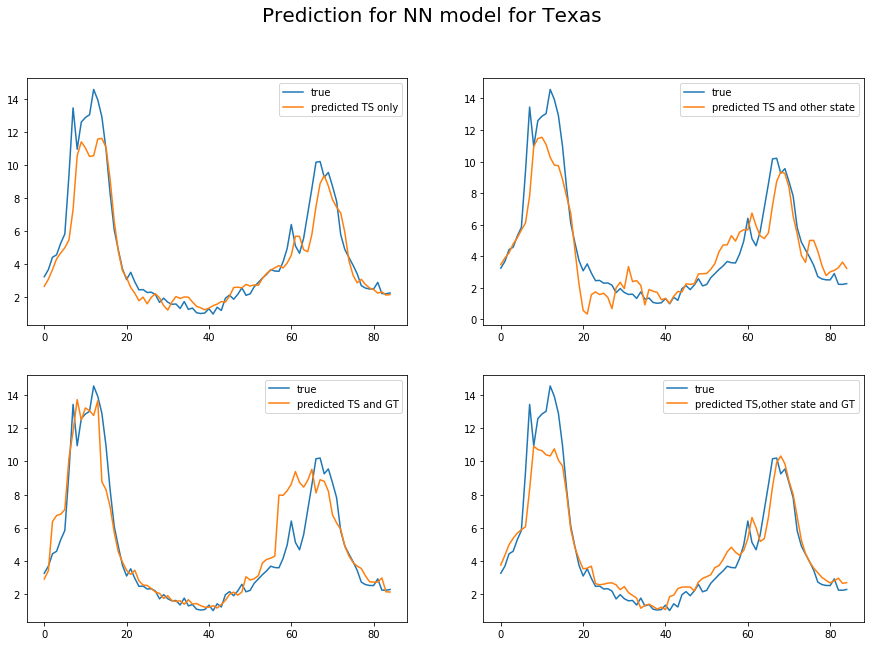

In [40]:
plot_prediction(RNN_TS1,RNN_TSOS1,RNN_TSGT1,RNN_TSOSGT1)

### LSTM

In [42]:
def LSTM_model(state,predictor_state = None,if_plot=True,if_gt = True,lag = 1):
    # def Neural network
    def lstm(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = 32
        epochs = epochs
        validation_split = 0.1
        verbose = verbose
        model = tf.keras.models.Sequential()
        model.add(LSTM(50, input_shape = (1,X_train.shape[2]),
                            return_sequences= True))
        model.add(Dropout(0.05))
        model.add(LSTM(100, return_sequences= False))
        model.add(Dropout(0.05))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X_train, X_test, X, y_train, y_test, y_all,scaler = get_data(state, 
                                                      lag,
                                                      with_gt=if_gt,
                                                      predictor_state=predictor_state)
    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)
    # Training Model
    # Training Model
    if predictor_state == None:
        predictor_state = ['flu_data']
    for i in range(26):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
     
    clf = LassoCV(alphas = [.1, .01, .001, .0001, .00001],tol = 0.05)
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = lstm(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
                 np.asarray(y_train),32,15,0)
    preds = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
    reverse_preds = scaler.inverse_transform(preds)
    
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, reverse_preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(reverse_preds, label='predicted')
        plt.legend()
        plt.show() 
    return reverse_preds

In [43]:
LSTM_TS1 = LSTM_model('Texas',None,False,False,1)
# Autocorrelation without GT
LSTM_TSOS1 = LSTM_model('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False, False,1)
# With goolge trend
LSTM_TSGT1 = LSTM_model('Texas',None,False,True,1)
# With goolge trend
LSTM_TSOSGT1 = LSTM_model('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)

Test RMSE:  1.2384442228744905
Test RMSE:  1.9432968478071413
Test RMSE:  1.3254700547884655
Test RMSE:  1.1189773754872123


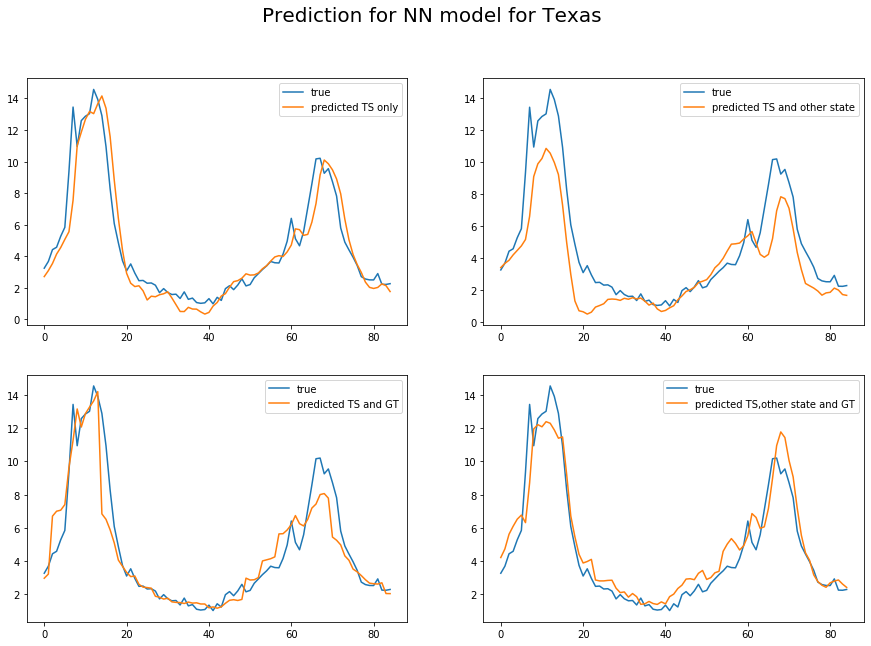

In [45]:
plot_prediction(LSTM_TS1,LSTM_TSOS1,LSTM_TSGT1,LSTM_TSOSGT1)

## RNN many to many

In [3]:
# flu data
flu_df = pd.read_csv('../data/clean_flu_data.csv')
flu_df

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Nebraska,New Mexico,...,Maine,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,2.199780,2.131910,...,0.357724,1.666830,0.414938,0.747696,1.143430,0.262990,2.80877,0.624179,1.102750,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,2.735320,1.963500,...,0.434855,1.636330,1.457980,0.410939,1.236530,0.369729,2.89079,0.958678,0.793794,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,3.311030,1.674860,...,0.421743,1.508600,1.408140,0.440583,1.225450,0.362121,2.41042,2.070390,0.791023,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,2.057610,2.354980,...,0.338409,2.144510,1.280070,0.755957,1.269020,0.358981,3.11632,1.670730,0.801311,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,0.376712,2.379830,...,0.176471,1.767610,1.827240,0.651859,1.265470,0.527357,2.99118,1.628450,0.779833,0.971705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2019-27,1.82690,1.78289,0.539926,1.79779,0.615385,0.504686,0.442087,1.006040,0.565824,...,0.604772,0.546315,0.000100,1.585350,0.927170,0.678007,3.95861,0.424056,0.360427,1.043860
457,2019-28,1.65596,1.85363,0.353838,1.61793,0.288184,0.538073,0.344234,0.773495,0.584795,...,0.558624,0.497344,0.000100,1.197440,0.900846,0.607034,4.21128,0.361664,0.503960,0.959798
458,2019-29,1.49702,1.73031,0.265041,1.43867,0.727069,0.478878,0.164783,0.987686,0.572213,...,0.448547,0.588998,0.000100,1.313940,0.870202,0.494300,4.04040,0.380417,0.368135,0.999950
459,2019-30,1.79673,1.76290,0.363840,1.32749,0.714286,0.437828,0.386100,1.047330,0.565417,...,0.511751,0.423831,0.000100,1.344060,0.800792,0.511351,3.19149,0.312256,0.316957,0.921444


In [4]:
state_name = []
target = []
for i,j in train_dfs.items():
    state_name.append(i)
    target.append(j['target_1'])
y_train = pd.DataFrame(data= np.array(target).T, columns = state_name)
y_train = y_train.reindex(sorted(y_train.columns), axis=1)

In [5]:
state_name = []
target = []
for i,j in test_dfs.items():
    state_name.append(i)
    target.append(j['target_1'])
y_test = pd.DataFrame(data= np.array(target).T, columns = state_name)
y_test = y_test.reindex(sorted(y_test.columns), axis=1)

In [6]:
flu_df = flu_df.reindex(sorted(flu_df.columns), axis=1)
flu_df

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,date
0,2.134770,0.875146,0.674721,0.696056,1.954120,0.660684,0.078309,0.100125,2.80877,1.604900,...,0.274655,2.06514,0.747696,1.476410,1.143430,0.510041,1.597410,0.465022,0.632911,2010-40
1,2.059990,1.128270,0.749939,0.674157,2.152660,0.628621,0.238095,0.368550,2.89079,1.713070,...,0.499492,2.09394,0.410939,1.357770,1.236530,1.040070,1.589680,0.581832,0.440621,2010-41
2,1.942240,0.586042,0.953365,0.514217,2.241730,0.804020,0.374158,0.337025,2.41042,2.012490,...,0.499550,2.10072,0.440583,1.482210,1.225450,0.904393,1.526720,1.188220,0.441798,2010-42
3,2.276500,0.967742,0.888804,0.413650,1.917480,0.909658,0.333542,0.460494,3.11632,2.387470,...,0.401638,2.20655,0.755957,1.443930,1.269020,0.955110,1.811710,1.010490,0.490305,2010-43
4,2.833710,0.683851,1.185730,1.090280,2.523260,0.971705,0.396743,0.222332,2.99118,2.656140,...,0.528096,2.36381,0.651859,1.252760,1.265470,0.786370,1.839860,1.096490,0.566636,2010-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.684589,1.601260,0.827794,0.615385,1.082530,1.043860,0.000100,0.000100,3.95861,1.014410,...,0.354925,1.82690,1.585350,1.271190,0.927170,0.539926,0.493546,0.872846,0.280899,2019-27
457,0.719655,1.430220,1.129820,0.288184,1.018560,0.959798,0.000100,0.000100,4.21128,0.936218,...,0.492126,1.65596,1.197440,1.052630,0.900846,0.353838,0.259488,0.704191,0.166021,2019-28
458,0.790052,1.248130,0.860512,0.727069,1.029430,0.999950,0.000100,0.000100,4.04040,0.900053,...,0.412116,1.49702,1.313940,0.896861,0.870202,0.265041,0.443590,0.830233,0.000100,2019-29
459,0.800068,0.000100,0.439354,0.714286,1.027130,0.921444,0.000100,0.000100,3.19149,0.987587,...,0.526205,1.79673,1.344060,2.392340,0.800792,0.363840,0.181269,0.642082,0.000100,2019-30


In [7]:
flu_df.shape

(461, 51)

In [8]:
def LSTM_model(flu_df,if_plot=True):
    # def Neural network
    def lstm(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = 32
        epochs = epochs
        validation_split = 0.1
        verbose = verbose
        model = tf.keras.models.Sequential()
        model.add(LSTM(50, input_shape = (1,X_train.shape[2]),
                            return_sequences= True))
        model.add(Dropout(0.05))
        model.add(LSTM(100, return_sequences= False))
        model.add(Dropout(0.05))
        model.add(tf.keras.layers.Dense(y_train.shape[1]))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    # X_data
    flu_df = flu_df.drop(columns = ['date'])
    flu_df = flu_df.reindex(sorted(flu_df.columns), axis=1)
    X_train = flu_df[:size]
    X_test = flu_df[size:]
    X_train, X_test, scaler = minmax_transform(X_train, X_test, return_scaler=True)
    # y_train
    state_name = []
    target = []
    for i,j in train_dfs.items():
        state_name.append(i)
        target.append(j['target_1'])
    y_train = pd.DataFrame(data= np.array(target).T, columns = state_name)
    y_train = y_train.reindex(sorted(y_train.columns), axis=1)
    # y_test
    state_name = []
    target = []
    for i,j in test_dfs.items():
        state_name.append(i)
        target.append(j['target_1'])
    y_test = pd.DataFrame(data= np.array(target).T, columns = state_name)
    y_test = y_test.reindex(sorted(y_test.columns), axis=1)
    scaler.transform(y_train)
    y_train, y_test = pd.DataFrame(scaler.transform(y_train)), y_test
    # Training Model
    predictors = X_train.columns
    for i in range(26):
        for col in predictors :
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
    clf = MultiTaskLassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109)
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = lstm(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
                 np.asarray(y_train),32,15,0)
    X_test = X_test[:-8]
    preds = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
    reverse_preds = scaler.inverse_transform(preds)
    return pd.DataFrame(data = reverse_preds,columns = flu_df.columns)

In [9]:
LSTM_TS1 = LSTM_model(flu_df,False)

In [10]:
np.sqrt(mean_squared_error(y_test['Texas'],LSTM_TS1['Texas']))

2.234023698383673